# IMDB Text Sentiment Classification with Conv1D

- Word Seq -> Embedding ->  **Conv1d**  ->  Linear -> SoftMax
 

**TODO Later sometime**
- LSTM/GRU

In [5]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets

In [6]:
%matplotlib inline

## Get IMDB sentiment classification data set
1. https://ai.stanford.edu/~amaas/data/sentiment/
1. Download, decompress

- The data was collected by Stanford researchers 
- and was used in a 2011 paper where a splitof 50-50 of the data was used for training and test. 
- An accuracy of 88.89% was achieved.

In [8]:
import os
os.listdir('../data/aclImdb/')

['imdb.vocab', 'imdbEr.txt', 'my_imdb.pkl', 'README', 'test', 'train']

In [10]:
# run $ python3 imdb_data_load.py to generate a pkl file from IMDB dataset

import imdb_data_load
#xtr, ytr, xte, yte = imdb_data_load.load_imdb('.data/imdb/aclImdb', loadpkl=False)
xtr, ytr, xte, yte = imdb_data_load.load_imdb('../data/aclImdb', loadpkl=True)

load_imdb():  ../data/aclImdb\my_imdb.pkl


### Let's have a look at the data

In [11]:
i = 0
print(f'label: {ytr[i]}\ndata[{i}]: (len: {len(xtr[i])}) {xtr[i][:10]}')
print('---')
print('xtr[0]>> ', xtr[0])
print('---')
print('xtr[500]>>', xtr[500])

label: 1
data[0]: (len: 140) ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the']
---
xtr[0]>>  ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........

## Vocabulary Making

- Vocab must be constructed with training data only.

In [12]:
vocab_src = set() # empty set
for word_list in xtr:
    vocab_src.update(word_list)
#
len(vocab_src)

280617

### Mapping from index to word, word to index

In [13]:
def get_maps(vocab):
    print('get_maps: ', len(vocab))
    word2indx, indx2word = {}, {}
    for v, w in enumerate(vocab):
        word2indx[w] = v
        indx2word[v] = w    # this can just be a list instead of {}
    return word2indx, indx2word
#

def get_words(i2w, inds):
    return [i2w[i] for i in inds]

word2indx_src, indx2word_src = get_maps(vocab_src)

get_maps:  280617


### Histogram of words in the whole dataset

- must include unknown word from test dataset

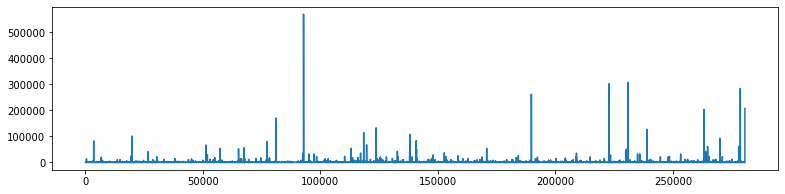

In [19]:
hist = np.zeros(len(vocab_src)+1, dtype=np.int)

for list_of_strings in [xtr, xte]:
    for wlst in list_of_strings:
        for w in wlst:
            if w in vocab_src:
                i = word2indx_src[w]
                hist[i] += 1
            else:
                hist[-1] += 1
                
#
plt.figure(figsize=(13,3))
plt.plot(hist)

In [15]:
print(f'* Maximum frequently used word: ', indx2word_src[np.argmax(hist)])
print(f'* Frequent Words:')
for i in range(len(vocab_src)):
    if hist[i] > 50000:
        print(indx2word_src[i], hist[i], end='; ')

* Maximum frequently used word:  the
* Frequent Words:
with 82569; /><br 100974; but 66282; film 54277; not 52140; are 56513; for 80919; in 169981; the 568735; his 54198; this 113726; The 67317; I 132498; it 107916; as 83130; be 50539; have 54009; to 261850; and 301919; you 50697; a 306960; that 126818; is 203056; movie 60762; was 92658; on 61197; of 283625; 

## Choose words and make a new vocab

In [16]:
mask = (7 <= hist ) & (hist < 50000)
print(f'Chosen words: {mask.sum()}  among  {mask.shape}')
windx = [i for i in range(len(mask)) if mask[i]]

# new vocab and maps
vocab = [indx2word_src[i] for i in windx] + ['<SOS>', '<EOS>', '<UNK>', '<PAD>']
word2indx, indx2word = get_maps(vocab)

print('size of new vocab: ', len(vocab))
#
unk_indx = word2indx['<UNK>']
pad_indx = word2indx['<PAD>']

Chosen words: 58437  among  (280618,)
get_maps:  58441
size of new vocab:  58441


In [17]:
len(vocab), len(set(vocab))

(58441, 58441)

## Convert sentence (word-list) to list of integer index
- Embedding will be used for NN model

### Examine the lengths of all the sentences

mean: 233.7872, min: 10  max: 2470  std: 173.7, median: 174.0


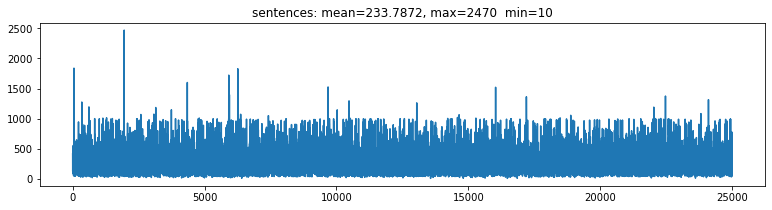

In [18]:
length = np.array([len(wlst) for wlst in xtr])
print(f'mean: {length.mean()}, min: {length.min()}  max: {length.max()}  std: {length.std():.1f}, median: {np.median(length)}')

plt.figure(figsize=(13,3))
plt.plot(length)
plt.title(f'sentences: mean={length.mean()}, max={max(length)}  min={min(length)}');

## Make Tensor array

In [20]:
max_len = 100  # we will use only 100 words per a sentence

In [21]:
def wseq2numpy(seq, vocab, word2indx, indx2word, max_len=200):
    """ seq: input, list of list of words, xtr or xte
        out: numpy array of ints [ [ 100, 23, 32], [32, 22, 10], ...]
    """
    print(len(seq), max_len)
    
    out = np.zeros((len(seq), max_len), dtype=np.int64)
    
    for i in range(len(seq)):
        s = seq[i]
        a = out[i]
        if len(s) >= max_len:   # if longer, trim
            s = s[:max_len]
        else:
            s = s + ['<PAD>' for i in range(max_len-len(s))]  # if shorter, pad
            
        for j, w in enumerate(s): # change to index 
            if w in vocab:
                a[j] = word2indx[w]
            else:
                a[j] = word2indx['<UNK>']
                
        if i == 0:
            print(f'{i} {seq[i]}')
    #
    return out

In [22]:
# set searching is much much faster than list searching
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

25000 100
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of'

In [23]:
xtrain.shape, xtrain[0]

((25000, 100),
 array([10784, 21809, 58439, 58439, 38149,  2602, 43474, 18134, 54926,
        58439, 58053, 33867, 58439, 46462, 30646, 49689, 48854, 11610,
        57597, 49921, 58439, 58439,  1209, 51908, 23893, 58439, 58439,
        44242,  3694, 46858, 27076, 58439, 54177, 58439, 10784, 58439,
        22456, 58439, 23573, 45808, 58439, 24776, 24043, 58439, 58439,
        58439,  3682, 58439, 38534, 58439, 58439, 33014, 50286, 31781,
        35018,  1370,  7764, 26310, 55238,  9259, 58439, 58439, 58439,
        58439, 58439, 58439, 11743, 25703, 43484, 18105, 27076, 58439,
        58439, 19023, 58439, 18987, 58439, 55238, 40059, 28422, 58439,
        50252, 58439, 27501, 58439, 26027, 58439, 37969, 35546, 26589,
        58439, 15924, 45912, 58439, 55222, 58439, 18182,  8243,  5904,
        54926], dtype=int64))

In [24]:
print(xtr[0])
print('---')
print(get_words(indx2word, xtrain[0]))

['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of', 'your', 't

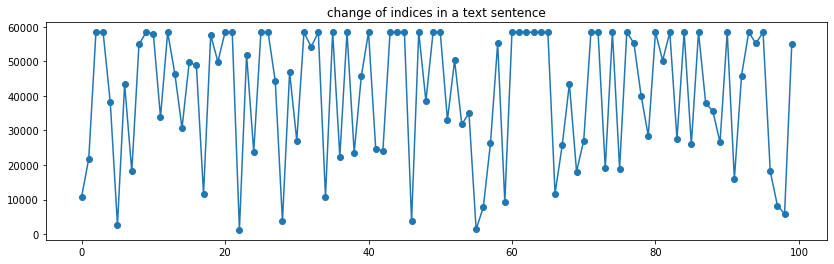

In [25]:
plt.figure(figsize=(14,4))
plt.plot(xtrain[0], '-o')
plt.title('change of indices in a text sentence');

In [26]:
word2indx['<UNK>']

58439

In [27]:
unique, counts = np.unique(xtrain[0], return_counts=True)
print(unique, counts)
print(indx2word[unique[np.argmax(counts)]])

[ 1209  1370  2602  3682  3694  5904  7764  8243  9259 10784 11610 11743
 15924 18105 18134 18182 18987 19023 21809 22456 23573 23893 24043 24776
 25703 26027 26310 26589 27076 27501 28422 30646 31781 33014 33867 35018
 35546 37969 38149 38534 40059 43474 43484 44242 45808 45912 46462 46858
 48854 49689 49921 50252 50286 51908 54177 54926 55222 55238 57597 58053
 58439] [ 1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  1  2  1  1 36]
<UNK>


---
## Dataset and Dataloader for PyTorch NN Modeling

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [29]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x  # np.array(N, max_len)
        self.y = y  # label
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [30]:
ds = Dataset(xtrain, ytr)
ds[21110]

(array([ 3933, 58439, 58439,  7927, 58439,   670, 58439, 10380, 27012,
         9444, 58439, 39975, 45525, 58439, 58439, 58439, 44722, 58439,
         6187, 28823, 58439, 58439,  2713, 48854, 58439, 58439, 58439,
        58439, 42455,  5965, 27525, 39794, 58439, 58439, 43724, 55968,
        47335, 50162,  3465, 51586, 33966, 58439,  6187, 43226, 58439,
        58439, 58439, 58439,  2760, 58439, 13741, 55238, 42455,  3465,
        21226, 45841, 31938, 58439, 10340, 22894, 58439, 56830, 19559,
        58439, 40527, 58439, 57322,  2713, 35887, 58439, 22894, 58439,
        18164, 47501, 16900, 39794, 58439, 58439, 43724, 55968, 19337,
         3465, 58439,  9590, 46311, 58439, 58439, 42335, 21601, 58439,
         1764, 27624, 22019,  6187, 58439, 58439, 45133, 28030, 44094,
        58439], dtype=int64), 0)

In [31]:
batch_size = 4
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

In [32]:
print(len(data_loader['train'].dataset), len(data_loader['val'].dataset))

for x, y in data_loader['train']:
    print(x.dtype, y.dtype)
    print(x.shape, y)
    break

25000 25000
torch.int64 torch.int64
torch.Size([4, 100]) tensor([1, 0, 0, 0])


## Network Design
Simple models with Conv1d():
1. nn.Embedding: word_index -> Euclidean Vector Mapping
1. nn.Conv1D()
1. nn.Linear()
1. AdaptiveAveragePooling()
1. Softmax + CrossEntropy = CrossEntropyLoss

### Practice layer by layer

#### nn.Embedding()

* Remember the output shape from embedding.
    - Batch x Sequence(Time) x Feature

In [33]:
vocab_size = len(vocab)
embed_dim = 9

emb = nn.Embedding(num_embeddings=vocab_size, 
                   embedding_dim=embed_dim,
                   padding_idx=word2indx['<PAD>'])

print( emb.weight.shape,'\n', emb.weight)
print('---')
for x, y in data_loader['train']:
    r = emb(x)
    print(f'input({x.shape}) --> embedded({r.shape})')
    break

torch.Size([58441, 9]) 
 Parameter containing:
tensor([[-0.4695,  1.2301,  2.6333,  ..., -0.6475,  1.0183, -0.2654],
        [-0.8242, -0.8450, -0.8883,  ..., -0.9998, -0.7255, -0.8130],
        [-0.6421, -0.4672,  0.1215,  ...,  0.2991,  0.0994, -0.1617],
        ...,
        [-0.5320,  0.7340,  1.7070,  ...,  0.7387, -0.7493, -0.0429],
        [ 0.5387, -0.3462,  1.1506,  ...,  0.7908, -1.3730, -0.3133],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)
---
input(torch.Size([4, 100])) --> embedded(torch.Size([4, 100, 9]))


#### nn.Conv1D()

- to apply the output of embedding, we changed the order of index

In [34]:
kernel_size = 11
out_channels= 5
conv1d = nn.Conv1d(in_channels=embed_dim, 
                   out_channels=out_channels, 
                   kernel_size=kernel_size, 
                   stride=1,
                   padding=kernel_size//2)  # <---- the same length in the output

r_perm = r.permute(0,2,1)
print(f'r_perm shape: {r_perm.shape}')
f = conv1d(r_perm)
print(f'conv1d shape: {f.shape}')

r_perm shape: torch.Size([4, 9, 100])
conv1d shape: torch.Size([4, 5, 100])


In [35]:
conv1d.out_channels, conv1d.stride

(5, (1,))

In [36]:
kernel_size = 11
out_channels=5
conv1d = nn.Conv1d(in_channels=embed_dim, 
                   out_channels=out_channels, 
                   kernel_size=kernel_size, 
                   stride=kernel_size//2,    # <---- the filter now jumps
                   padding=kernel_size//2)

r_perm = r.permute(0,2,1)
print(f'r_perm shape: {r_perm.shape}')
f = conv1d(r_perm)
print(f'conv1d shape: {f.shape}')

r_perm shape: torch.Size([4, 9, 100])
conv1d shape: torch.Size([4, 5, 20])


#### nn.Linear()

In [37]:
in_dim = f.shape[-1] * f.shape[-2]
out_dim = 2 # sentiment: [pos, neg]
linear = nn.Linear(in_features=in_dim, out_features=2)

flatten = nn.Flatten()
score = linear(flatten(f))

print(score.shape)

torch.Size([4, 2])


### Make NN Model
- Pytorch Custom Module: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

In [46]:
class Conv1dModel(nn.Module):
    def __init__(self, vocab_len, kernel_size=5, out_channels=5, embedding_dim=40, seq_len=100, n_targets=2):
        super(Conv1dModel, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_len, 
                                      embedding_dim=embedding_dim, 
                                      padding_idx=word2indx['<PAD>'])
        
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, 
                               out_channels=out_channels, 
                               kernel_size=kernel_size, 
                               stride=kernel_size//2, padding=kernel_size//2) # [B, 5, 20]
        
        self.tanh = nn.Tanh()
        
        self.flatten = nn.Flatten()

        # nn.Linear() depends on the size of input sequence. 
        # We can avoid this using AdaptiveAvgPool1d(); comes later
        #
        in_features = int((self.conv1.out_channels * seq_len) / self.conv1.stride[0]) # calculate!
        self.linear = nn.Linear(in_features=in_features, out_features=n_targets)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.permute(0,2,1)
        x =  self.tanh(self.conv1(x))
        x = self.flatten(x)
        x = self.linear(x)
        
        return x
#

class Conv1dModel_Relu_AvgPooling(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, kernel_size=5, n_target=2):
        super().__init__()
        emb_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=pad_indx)
        self.conv1 = nn.Conv1d(emb_dim,    emb_dim//2, kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.conv2 = nn.Conv1d(emb_dim//2, emb_dim//4, kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.conv3 = nn.Conv1d(emb_dim//4, n_target,   kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.bn1 = nn.BatchNorm1d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm1d(self.conv2.out_channels)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0,2,1) # NLC -> NCL
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        return x
#


class Conv1dModel_AvgPooling(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, kernel_size=5, n_target=2):
        super(Conv1dModel_AvgPooling, self).__init__()
        emb_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=pad_indx)
        self.conv1 = nn.Conv1d(emb_dim,    emb_dim//2, kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.conv2 = nn.Conv1d(emb_dim//2, emb_dim//4, kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.conv3 = nn.Conv1d(emb_dim//4, n_target,   kernel_size=kernel_size, padding=kernel_size//2, stride=kernel_size//2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.bn1 = nn.BatchNorm1d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm1d(self.conv2.out_channels)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0,2,1) # NLC -> NCL
        x = nn.functional.elu(self.bn1(self.conv1(x)))
        x = nn.functional.elu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        return x
#

def make_model(vocab_size, embedding_dim, kernel_size=5, option=1):
    if option == 1:
        return Conv1dModel(vocab_size, embedding_dim=embedding_dim, kernel_size=kernel_size, out_channels=50)
    elif option == 2:
        return Conv1dModel_AvgPooling(vocab_size, embedding_dim=embedding_dim, kernel_size=kernel_size, n_target=2)
    elif option == 3:
        return Conv1dModel_Relu_AvgPooling(vocab_size, embedding_dim=embedding_dim, kernel_size=kernel_size, n_target=2)
    else:
        return None
#

In [39]:
net = make_model(vocab_size, embedding_dim=50)
print(net)
net(x).shape

Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)


torch.Size([4, 2])

In [40]:
net = make_model(vocab_size, embedding_dim=50, option=2)
print(net)
print(net(x).shape)

Conv1dModel_AvgPooling(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 25, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(25, 12, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(12, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([4, 2])


## Training Loop

In [60]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None, lr_scheduler=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    #
    if lr_scheduler is not None:
        lr = []
        
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        # end mini-batch loop
        
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
        
        # best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            print(f' >> best val accuracy updated: {best_acc} at epoch {epoch}.')
        #
        # record for history return
        if hist is not None:
            hist['tloss'].append(tr_loss)
            hist['vloss'].append(val_loss) 
            hist['tacc'].append(tr_acc)
            hist['vacc'].append(val_acc)
            
        if lr_scheduler is not None:
            lr.append(lr_scheduler.get_lr()) # the lr used in optim.
            lr_scheduler.step()
        # end epoch-loop
        
    if lr_scheduler is not None:
        hist['lr'] = lr
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    model.train()
    return loss, acc
#

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
#

def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

## Training Setup

In [49]:
import training_loop as tx
#
vocab_len = len(vocab)

In [51]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu') # for debuging
print(device)


model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
total number of parameters:  2939602 embeddin:  2922050


In [53]:
tx.count_params(model.embedding)

2922050

## First Trial

Epoch 1, tloss 14.12 t_acc: 0.52  vloss 3.40  v_acc: 0.56
Epoch 2, tloss 1.79 t_acc: 0.71  vloss 2.05  v_acc: 0.68  
Epoch 3, tloss 0.71 t_acc: 0.85  vloss 1.76  v_acc: 0.71  
Epoch 4, tloss 0.34 t_acc: 0.91  vloss 1.79  v_acc: 0.73  
Epoch 5, tloss 0.17 t_acc: 0.95  vloss 1.92  v_acc: 0.74  
Epoch 10, tloss 0.03 t_acc: 0.99  vloss 2.42  v_acc: 0.75 
best model is loaded. finished training_loop(). 4.        
Wall time: 9.87 s


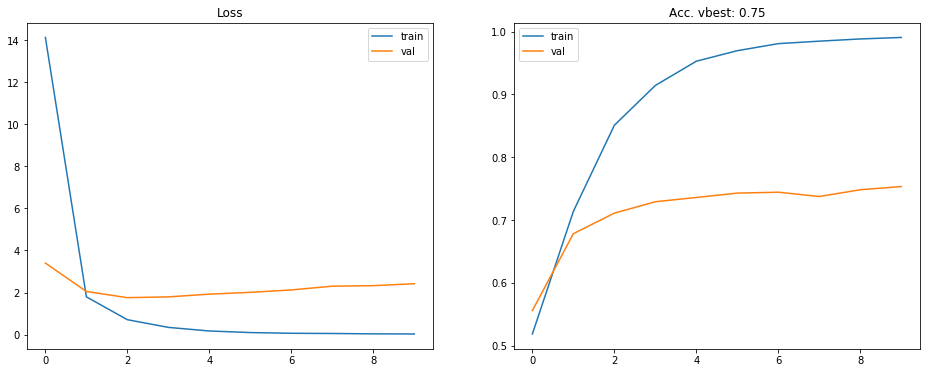

In [56]:
%%time
history = tx.training_loop(10, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            history, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

Epoch 1, tloss 0.03 t_acc: 0.99  vloss 2.43  v_acc: 0.75
Epoch 2, tloss 0.03 t_acc: 0.99  vloss 2.58  v_acc: 0.75
Epoch 3, tloss 0.04 t_acc: 0.99  vloss 2.76  v_acc: 0.75  
Epoch 4, tloss 0.05 t_acc: 0.99  vloss 2.89  v_acc: 0.75
Epoch 5, tloss 0.06 t_acc: 0.99  vloss 3.14  v_acc: 0.75
Epoch 10, tloss 0.26 t_acc: 0.97  vloss 5.10  v_acc: 0.75
best model is loaded. finished training_loop(). 
Wall time: 6.45 s


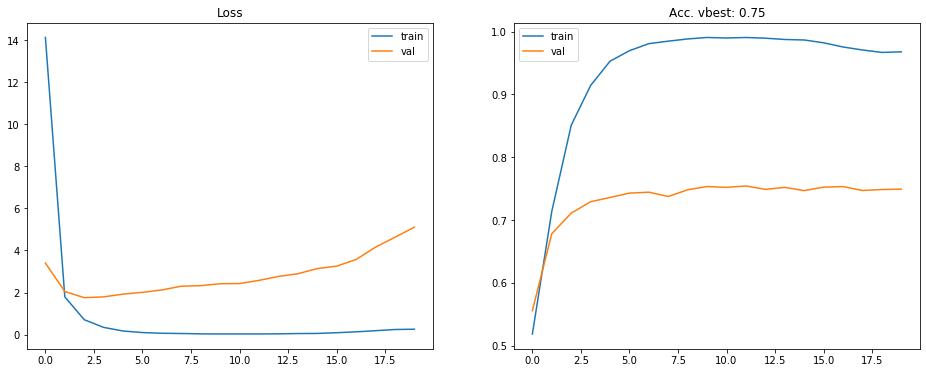

In [58]:
%%time
history = tx.training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history,
                        lr_scheduler=lr_scheduler, device=device)
tx.plot_history(history)

## Try with CosineAnnealing()

In [61]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', count_params(model), 'embeddin: ', count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
total number of parameters:  2939602 embeddin:  2922050


## First Trial

Epoch 1, tloss 19.65 t_acc: 0.51  vloss 3.72  v_acc: 0.58
 >> best val accuracy updated: 0.5754 at epoch 1.
Epoch 2, tloss 1.79 t_acc: 0.74  vloss 1.92  v_acc: 0.70
 >> best val accuracy updated: 0.69844 at epoch 2.
Epoch 3, tloss 0.61 t_acc: 0.87  vloss 1.63  v_acc: 0.72
 >> best val accuracy updated: 0.72376 at epoch 3.
Epoch 4, tloss 0.23 t_acc: 0.93  vloss 1.53  v_acc: 0.74
 >> best val accuracy updated: 0.7362 at epoch 4.
Epoch 5, tloss 0.07 t_acc: 0.98  vloss 1.54  v_acc: 0.74
 >> best val accuracy updated: 0.74344 at epoch 5.
 >> best val accuracy updated: 0.74432 at epoch 6.
 >> best val accuracy updated: 0.74624 at epoch 7.
 >> best val accuracy updated: 0.7468 at epoch 8.
 >> best val accuracy updated: 0.74696 at epoch 12.
 >> best val accuracy updated: 0.74716 at epoch 13.
 >> best val accuracy updated: 0.74756 at epoch 14.
 >> best val accuracy updated: 0.74784 at epoch 15.
 >> best val accuracy updated: 0.74816 at epoch 17.
 >> best val accuracy updated: 0.74828 at epoch 1

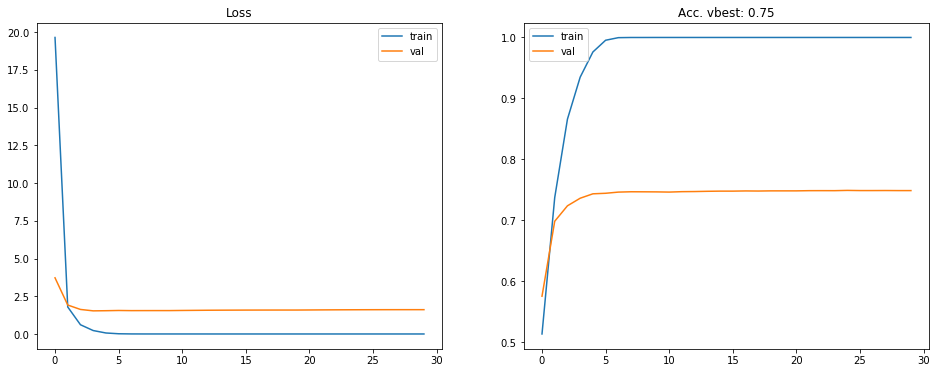

In [62]:
%%time
history = training_loop(30, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

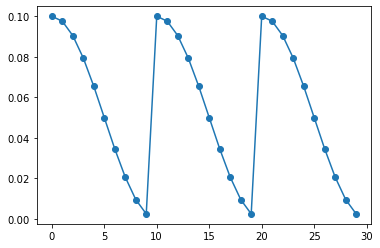

In [63]:
plt.plot(history['lr'], '-o')

## Overfitting is occurring!
Below
- lr_scheduler change
- The same result
- more data!

## With smaller learning rate

In [64]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', count_params(model), 'embeddin: ', count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=15)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (conv1): Conv1d(50, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
total number of parameters:  2939602 embeddin:  2922050


## First Trial

Epoch 1, tloss 0.10 t_acc: 0.98  vloss 0.84  v_acc: 0.71
 >> best val accuracy updated: 0.71148 at epoch 1.
Epoch 2, tloss 0.08 t_acc: 0.98  vloss 0.87  v_acc: 0.71
 >> best val accuracy updated: 0.71352 at epoch 2.
Epoch 3, tloss 0.07 t_acc: 0.99  vloss 0.92  v_acc: 0.71
Epoch 4, tloss 0.05 t_acc: 0.99  vloss 0.93  v_acc: 0.72
 >> best val accuracy updated: 0.71572 at epoch 4.
Epoch 5, tloss 0.04 t_acc: 1.00  vloss 0.96  v_acc: 0.72
 >> best val accuracy updated: 0.7176 at epoch 5.
 >> best val accuracy updated: 0.71848 at epoch 8.
 >> best val accuracy updated: 0.71924 at epoch 9.
 >> best val accuracy updated: 0.72008 at epoch 12.
 >> best val accuracy updated: 0.7202 at epoch 16.
 >> best val accuracy updated: 0.72132 at epoch 17.
 >> best val accuracy updated: 0.72164 at epoch 19.
 >> best val accuracy updated: 0.72276 at epoch 20.
 >> best val accuracy updated: 0.72352 at epoch 24.
 >> best val accuracy updated: 0.72384 at epoch 25.
 >> best val accuracy updated: 0.72552 at epoch

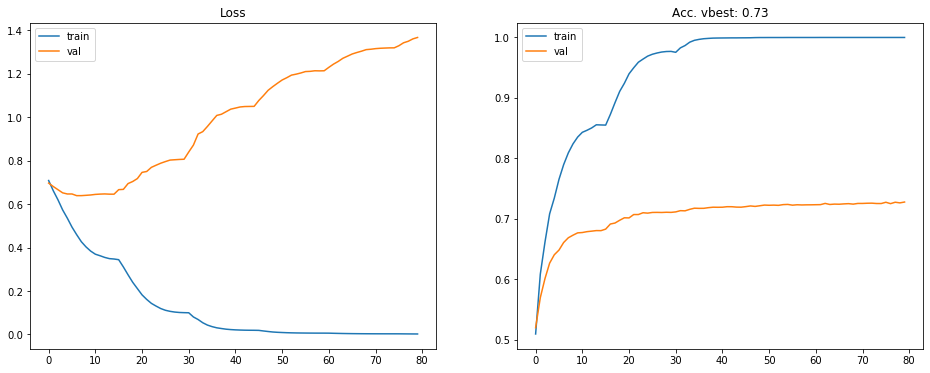

In [66]:
%%time
history = training_loop(50, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

## Reduced Embedding Dim for the 2nd Model with AvgPooling1D()

In [67]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=1, vocab_size=vocab_len, kernel_size=5, embedding_dim=2).to(device)
print(model)
print('total number of parameters: ', count_params(model), 'embeddin: ', count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

cuda
Conv1dModel(
  (embedding): Embedding(58441, 2, padding_idx=58440)
  (conv1): Conv1d(2, 50, kernel_size=(5,), stride=(2,), padding=(2,))
  (tanh): Tanh()
  (flatten): Flatten()
  (linear): Linear(in_features=2500, out_features=2, bias=True)
)
total number of parameters:  122434 embeddin:  116882


## First Trial

Epoch 1, tloss 4.57 t_acc: 0.50  vloss 2.06  v_acc: 0.50
 >> best val accuracy updated: 0.4982 at epoch 1.
Epoch 2, tloss 1.72 t_acc: 0.54  vloss 1.41  v_acc: 0.54
 >> best val accuracy updated: 0.53532 at epoch 2.
Epoch 3, tloss 0.90 t_acc: 0.64  vloss 0.85  v_acc: 0.62
 >> best val accuracy updated: 0.61812 at epoch 3.
Epoch 4, tloss 0.52 t_acc: 0.76  vloss 0.73  v_acc: 0.68
 >> best val accuracy updated: 0.67964 at epoch 4.
Epoch 5, tloss 0.36 t_acc: 0.85  vloss 0.70  v_acc: 0.72
 >> best val accuracy updated: 0.71528 at epoch 5.
 >> best val accuracy updated: 0.71852 at epoch 6.
 >> best val accuracy updated: 0.72664 at epoch 7.
 >> best val accuracy updated: 0.73 at epoch 8.
 >> best val accuracy updated: 0.73072 at epoch 10.
 >> best val accuracy updated: 0.73148 at epoch 13.
 >> best val accuracy updated: 0.73212 at epoch 15.
 >> best val accuracy updated: 0.73296 at epoch 16.
 >> best val accuracy updated: 0.73312 at epoch 18.
 >> best val accuracy updated: 0.73316 at epoch 19.

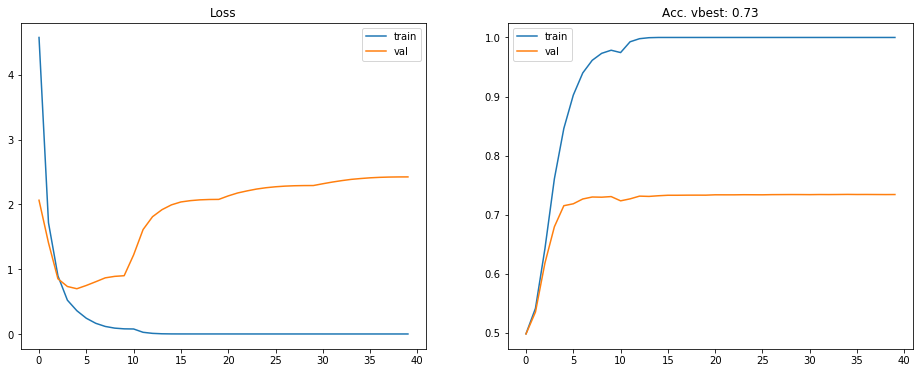

In [68]:
%%time
history = training_loop(40, optimizer, model, criterion,
                        data_loader['train'], data_loader['val'], 
                        history, 
                        lr_scheduler=lr_scheduler)
plot_history(history)

## Embedding Space Analysis

torch.Size([58441, 2])
x:  (25000, 100) <class 'numpy.ndarray'>
unique(x[y==0]):  (44707,)
unique(x[y==1]):  (44949,)
x:  torch.Size([25000, 1, 100])
e:  torch.Size([25000, 1, 100, 2])
25000 <class 'numpy.ndarray'> (12500,) [0 0 0 ... 0 0 0]
en, ep:  torch.Size([12500, 1, 100, 2]) torch.Size([12500, 1, 100, 2])
torch.Size([12500, 1, 100, 2])
en, ep:  torch.Size([1250000, 2]) torch.Size([1250000, 2])


Text(0.5, 1.0, 'Embedding weight vectors. G: all, B: pos, R: neg')

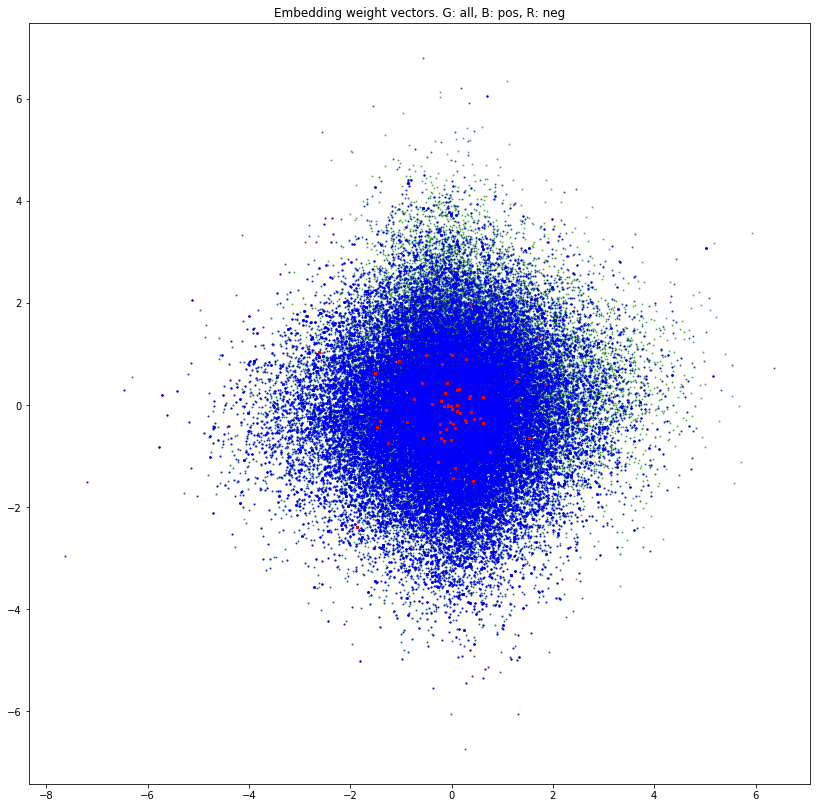

In [69]:
plt.figure(figsize=(14,14))
w = model.embedding.weight.data.cpu()
print(w.shape)
plt.scatter(w[:,0], w[:,1], alpha=0.5, s=1, c='g') # un-used weights exist due to sentence trimming.

with torch.no_grad():
    x, y = data_loader['train'].dataset[:] # the first in the dataset
    y = np.array(y)
    
    print('x: ', x.shape, type(x))
    uniq = np.unique(x[y==0])
    print('unique(x[y==0]): ', uniq.shape)
    print('unique(x[y==1]): ', np.unique(x[y==1]).shape)
    
    x = torch.from_numpy(x).to(device).unsqueeze(1) #
    print('x: ', x.shape)
    e = model.embedding(x).cpu()
print('e: ', e.shape)

yn = y[y==0]
print(len(y), type(y), yn.shape, yn)

e_neg = e[yn]
e_pos = e[y==1]
print('en, ep: ', e_neg.shape, e_pos.shape)
print(e_neg.shape)

e_neg = e_neg.reshape(-1,2)
e_pos = e_pos.reshape(-1,2)
print('en, ep: ', e_neg.shape, e_pos.shape)

plt.scatter(e_pos[:,0], e_pos[:,1], c='b', alpha=0.3, s=1)
plt.scatter(e_neg[:,0], e_neg[:,1], c='r', alpha=0.3, s=2)

plt.title('Embedding weight vectors. G: all, B: pos, R: neg')
# 

torch.Size([1250000, 2])


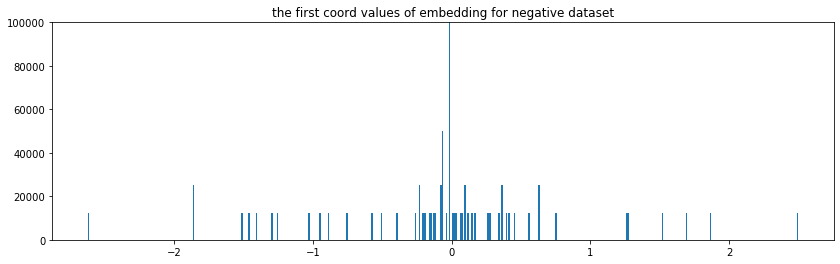

In [70]:
print(e_neg.shape)
plt.figure(figsize=(14,4))
plt.hist(e_neg[:,0].reshape(-1), bins=500)
plt.ylim((0,100000))
plt.title('the first coord values of embedding for negative dataset');

torch.Size([25000, 1, 100, 2])

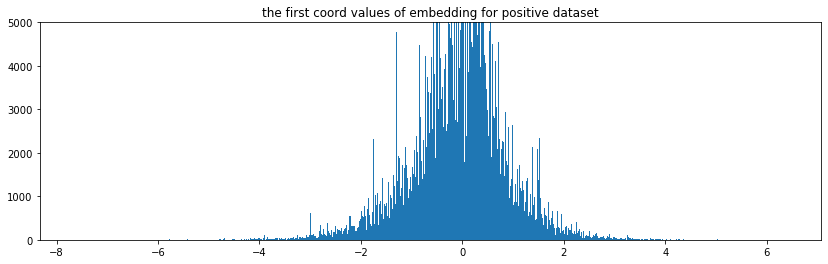

In [71]:
plt.figure(figsize=(14,4))
plt.hist(e_pos[:,0].reshape(-1), bins=1000)
plt.ylim((0,5000))
plt.title('the first coord values of embedding for positive dataset')
e.shape

## Hypter parameters
- the number of words (size of vocab)
- maximum length of the sequence
    - choose this number will change the number of vocabs of the training data. So, practically this selection should precede the choice of word dictionary (which was done based on the histogram of occurance)
- embedding dimension
- architecture of the feature network
    - 1D resnet, e.g.
- learning rate, schedule

## References
- [https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data](https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data)
- https://github.com/lesley2958/twilio-sent-analysis
- https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch

End.

---
### ReLU

In [72]:
import training_loop as tx

In [73]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)    # <---- ReLU instead of ELU
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820


Epoch 1, tloss 0.68 t_acc: 0.57  vloss 0.52  v_acc: 0.74
Epoch 2, tloss 0.31 t_acc: 0.88  vloss 1.02  v_acc: 0.59  
Epoch 3, tloss 0.08 t_acc: 0.98  vloss 1.01  v_acc: 0.78
Epoch 4, tloss 0.01 t_acc: 1.00  vloss 1.13  v_acc: 0.77  
Epoch 5, tloss 0.00 t_acc: 1.00  vloss 1.15  v_acc: 0.77
Epoch 40, tloss 0.00 t_acc: 1.00  vloss 1.46  v_acc: 0.77
best model is loaded. finished training_loop(). 


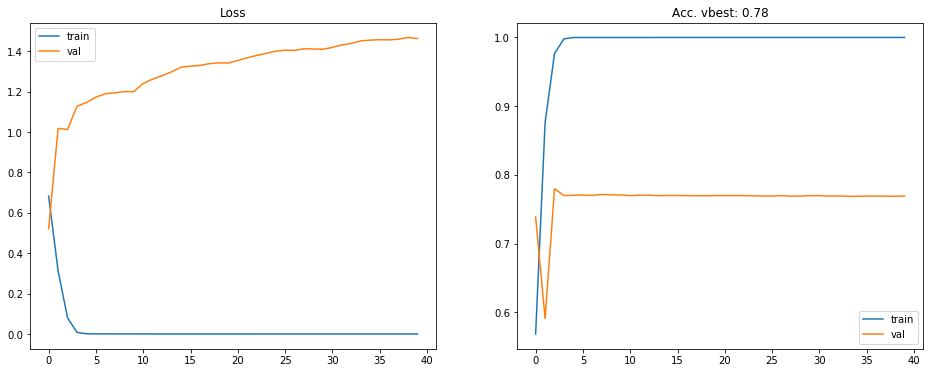

In [75]:
history = tx.training_loop(40, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           history, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.69 t_acc: 0.53  vloss 0.69  v_acc: 0.54
Epoch 2, tloss 0.57 t_acc: 0.70  vloss 0.61  v_acc: 0.70  
Epoch 3, tloss 0.38 t_acc: 0.83  vloss 0.52  v_acc: 0.77  
Epoch 4, tloss 0.23 t_acc: 0.91  vloss 0.57  v_acc: 0.78
Epoch 5, tloss 0.12 t_acc: 0.96  vloss 0.71  v_acc: 0.77  
Epoch 40, tloss 0.00 t_acc: 1.00  vloss 1.48  v_acc: 0.76
best model is loaded. finished training_loop(). 
Wall time: 35.9 s


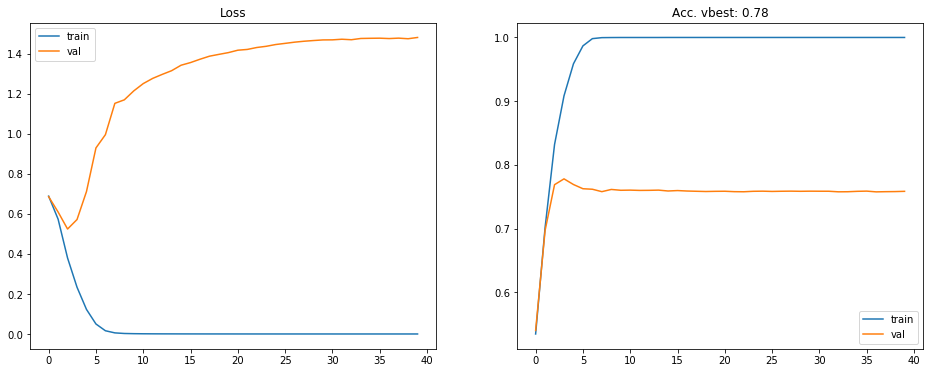

In [76]:
%%time

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01                                                                  # <----- learning rate change from 0.1 to 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=40)

history = tx.training_loop(40, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           history, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history)

### weight decay

The loss is modified by adding the sum of squared weights. 
$$
    L'(w) =  L(w) + \lambda \sum w_i^2
$$
- Here $\lambda$ is the parameter of **weight decay**. 
- This gives a role of regularization (preventing overfitting) by penalizing large values of some weights.

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.69 t_acc: 0.52  vloss 0.69  v_acc: 0.52
Epoch 2, tloss 0.68 t_acc: 0.56  vloss 0.69  v_acc: 0.51
Epoch 3, tloss 0.68 t_acc: 0.57  vloss 0.69  v_acc: 0.54
Epoch 4, tloss 0.67 t_acc: 0.58  vloss 0.69  v_acc: 0.54  
Epoch 5, tloss 0.67 t_acc: 0.60  vloss 0.68  v_acc: 0.57
Epoch 60, tloss 0.02 t_acc: 1.00  vloss 0.53  v_acc: 0.79  
best model is loaded. finished training_loop(). 
Wall time: 54.9 s


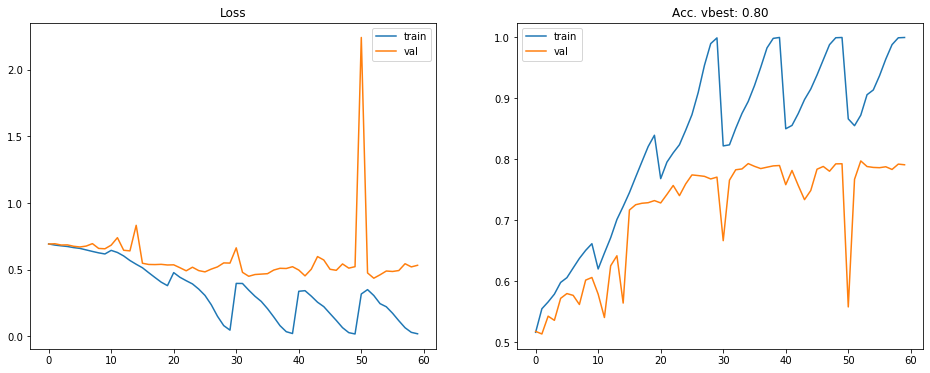

In [86]:
%%time

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)     # <----- weight decay
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = tx.training_loop(60, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history)

In [98]:
import importlib
importlib.reload(tx)

<module 'training_loop' from 'D:\\git\\iadl\\class\\training_loop.py'>

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.64 t_acc: 0.61  vloss 0.73  v_acc: 0.60
Epoch 2, tloss 0.52 t_acc: 0.74  vloss 0.53  v_acc: 0.73acc: 0.60516)    
Epoch 3, tloss 0.50 t_acc: 0.76  vloss 0.52  v_acc: 0.74acc: 0.7388)    
Epoch 4, tloss 0.49 t_acc: 0.77  vloss 0.54  v_acc: 0.72acc: 0.75972)    
Epoch 5, tloss 0.48 t_acc: 0.77  vloss 0.49  v_acc: 0.76
Epoch 60, tloss 0.06 t_acc: 1.00  vloss 0.52  v_acc: 0.79acc: 0.87452)    
best model

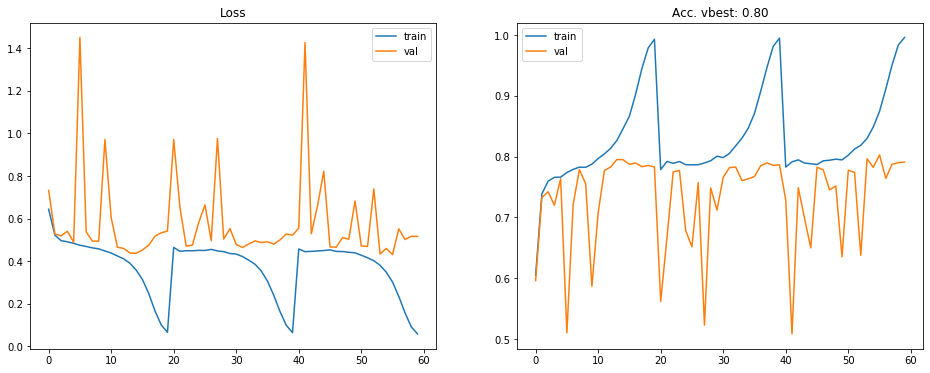

In [92]:
%%time

batch_size = 64                                                                                                    # <----- smaller batch size for stochastic search
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)

history = tx.training_loop(60, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.67 t_acc: 0.56  vloss 0.59  v_acc: 0.68
Epoch 2, tloss 0.55 t_acc: 0.73  vloss 0.55  v_acc: 0.71acc: 0.5622)    
Epoch 3, tloss 0.52 t_acc: 0.75  vloss 0.56  v_acc: 0.71cc: 0.7258)    
Epoch 4, tloss 0.51 t_acc: 0.75  vloss 0.59  v_acc: 0.68
Epoch 5, tloss 0.51 t_acc: 0.75  vloss 0.62  v_acc: 0.66
Epoch 60, tloss 0.06 t_acc: 1.00  vloss 0.53  v_acc: 0.79cc: 0.84532)     
best model is loaded. finishe

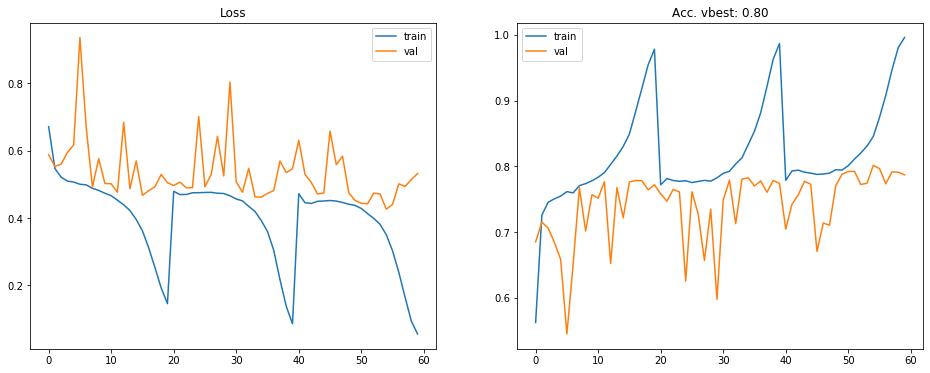

In [93]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(60, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.69 t_acc: 0.53  vloss 0.69  v_acc: 0.54
Epoch 2, tloss 0.67 t_acc: 0.57  vloss 0.68  v_acc: 0.57cc: 0.53312)    
Epoch 3, tloss 0.65 t_acc: 0.61  vloss 0.66  v_acc: 0.60acc: 0.57264)    
Epoch 4, tloss 0.63 t_acc: 0.64  vloss 0.65  v_acc: 0.62acc: 0.61148)    
Epoch 5, tloss 0.61 t_acc: 0.66  vloss 0.64  v_acc: 0.63acc: 0.64216)    
Epoch 30, tloss 0.30 t_acc: 0.88  vloss 0.71  v_acc: 0.71acc: 0.8606

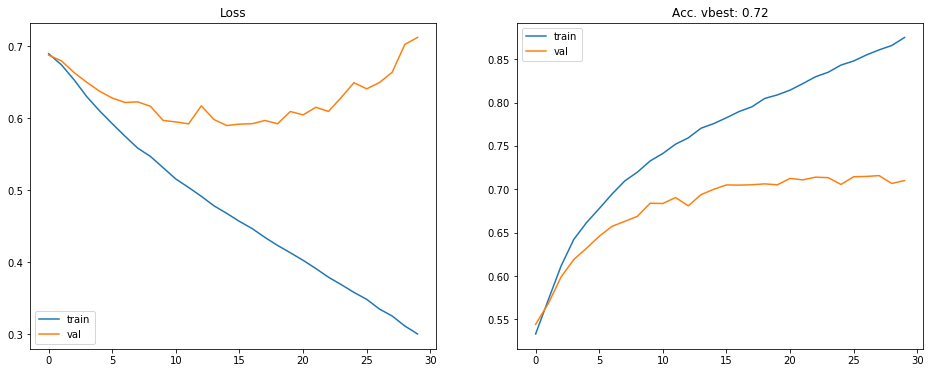

In [94]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adadelta(model.parameters())     # <--- Adadelta()
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(30, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.67 t_acc: 0.58  vloss 0.65  v_acc: 0.62
Epoch 2, tloss 0.60 t_acc: 0.68  vloss 0.61  v_acc: 0.67acc: 0.57928)    
Epoch 3, tloss 0.55 t_acc: 0.72  vloss 0.58  v_acc: 0.69acc: 0.67628)    
Epoch 4, tloss 0.51 t_acc: 0.75  vloss 0.56  v_acc: 0.71acc: 0.72332)    
Epoch 5, tloss 0.48 t_acc: 0.77  vloss 0.55  v_acc: 0.72acc: 0.75112)    
Epoch 30, tloss 0.21 t_acc: 0.92  vloss 0.60  v_acc: 0.76acc: 0.911

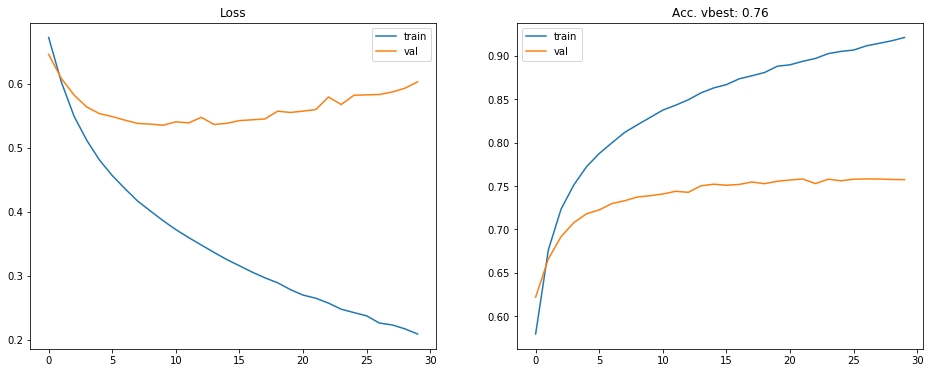

In [96]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adagrad(model.parameters())     # <--- Adadelta()
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(30, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.68 t_acc: 0.55  vloss 0.66  v_acc: 0.60
Epoch 2, tloss 0.58 t_acc: 0.69  vloss 0.57  v_acc: 0.70   (tacc: 0.5484)    
Epoch 3, tloss 0.48 t_acc: 0.77  vloss 0.55  v_acc: 0.72   (tacc: 0.69252)    
Epoch 4, tloss 0.39 t_acc: 0.82  vloss 0.55  v_acc: 0.74 (tacc: 0.77456)    
Epoch 5, tloss 0.33 t_acc: 0.86  vloss 0.56  v_acc: 0.75  (tacc: 0.82452)    
Epoch 30, tloss 0.00 t_acc: 1.00  vloss 1.92  v_acc

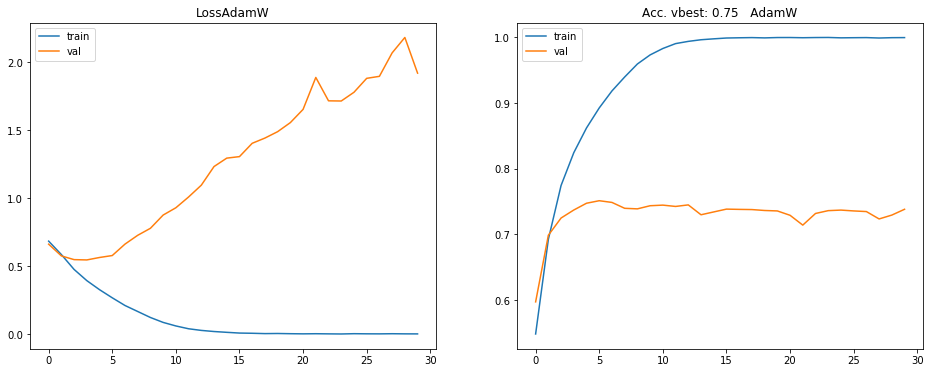

In [99]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.AdamW(model.parameters())     # <--- Adadelta()
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(30, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history, text=optimizer.__class__.__name__)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.69 t_acc: 0.53  vloss 0.68  v_acc: 0.55
Epoch 2, tloss 0.66 t_acc: 0.60  vloss 0.66  v_acc: 0.60   (tacc: 0.52924)    
Epoch 3, tloss 0.62 t_acc: 0.66  vloss 0.65  v_acc: 0.62   (tacc: 0.60244)    
Epoch 4, tloss 0.58 t_acc: 0.69  vloss 0.60  v_acc: 0.67   (tacc: 0.65504)    
Epoch 5, tloss 0.55 t_acc: 0.72  vloss 0.59  v_acc: 0.68   (tacc: 0.69288)    
Epoch 30, tloss 0.21 t_acc: 0.92  vloss 0.67  v

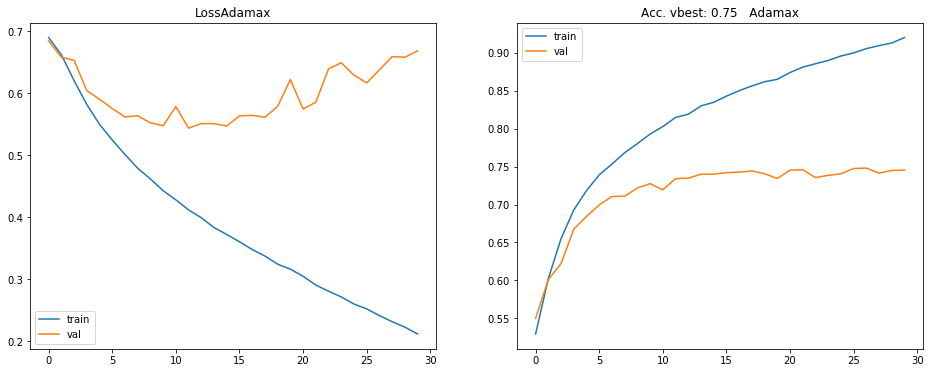

In [100]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adamax(model.parameters())     # <--- Adadelta()
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.
        
history = tx.training_loop(30, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history, text=optimizer.__class__.__name__)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.50 t_acc: 0.74  vloss 0.46  v_acc: 0.78
Epoch 2, tloss 0.27 t_acc: 0.89  vloss 0.46  v_acc: 0.80   (tacc: 0.74384)    
Epoch 3, tloss 0.15 t_acc: 0.94  vloss 0.66  v_acc: 0.78   (tacc: 0.88728)    
Epoch 4, tloss 0.07 t_acc: 0.98  vloss 0.91  v_acc: 0.77
Epoch 5, tloss 0.03 t_acc: 0.99  vloss 1.20  v_acc: 0.77
Epoch 30, tloss 0.01 t_acc: 1.00  vloss 2.36  v_acc: 0.76
best model is loaded. finished tr

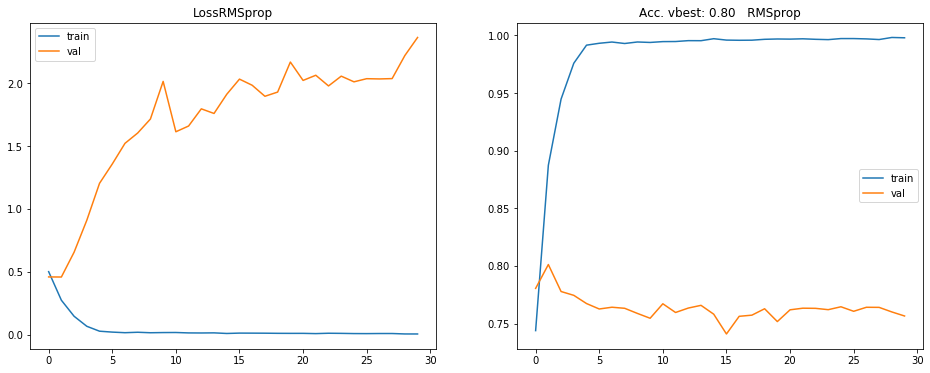

In [101]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.RMSprop(model.parameters())     # <--- Adadelta()
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(30, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history, text=optimizer.__class__.__name__)

In [ ]:
%%time

batch_size = 16                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.RMSprop(model.parameters())     
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(30, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history, text=optimizer.__class__.__name__)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.51 t_acc: 0.74  vloss 0.42  v_acc: 0.80
Epoch 2, tloss 0.32 t_acc: 0.87  vloss 0.43  v_acc: 0.80   (tacc: 0.73748)    
Epoch 3, tloss 0.22 t_acc: 0.91  vloss 0.63  v_acc: 0.76  (tacc: 0.86608)    
Epoch 4, tloss 0.14 t_acc: 0.95  vloss 0.62  v_acc: 0.78
Epoch 5, tloss 0.09 t_acc: 0.97  vloss 0.80  v_acc: 0.77


cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.69 t_acc: 0.52  vloss 0.69  v_acc: 0.52
Epoch 2, tloss 0.69 t_acc: 0.52  vloss 0.69  v_acc: 0.52   (tacc: 0.51612)    
Epoch 3, tloss 0.69 t_acc: 0.53  vloss 0.69  v_acc: 0.53   (tacc: 0.52288)    
Epoch 4, tloss 0.69 t_acc: 0.54  vloss 0.69  v_acc: 0.53   (tacc: 0.5334)    
Epoch 5, tloss 0.69 t_acc: 0.55  vloss 0.69  v_acc: 0.54   (tacc: 0.54236)    
Epoch 50, tloss 0.61 t_acc: 0.67  vloss 0.67  v_

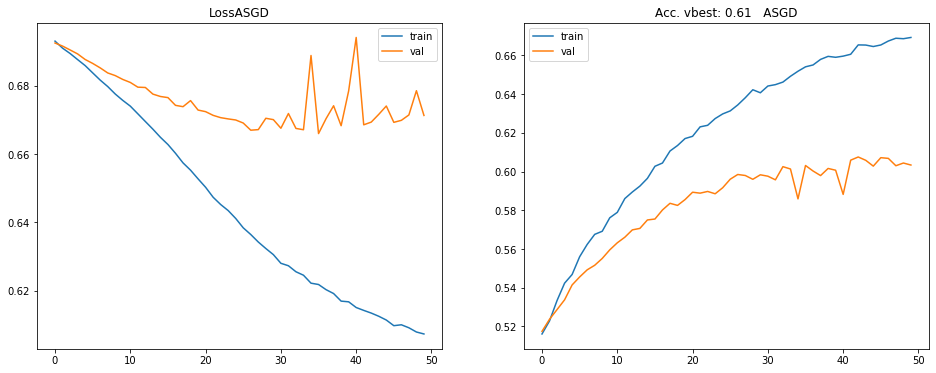

In [105]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.ASGD(model.parameters())     # <--- Adadelta()
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(50, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history, text=optimizer.__class__.__name__)

cuda
Conv1dModel_Relu_AvgPooling(
  (embedding): Embedding(58441, 20, padding_idx=58440)
  (conv1): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(5, 2, kernel_size=(5,), stride=(2,), padding=(2,))
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
total number of parameters:  1170167 embeddin:  1168820
Epoch 1, tloss 0.69 t_acc: 0.53  vloss 0.73  v_acc: 0.51
Epoch 2, tloss 0.68 t_acc: 0.57  vloss 0.71  v_acc: 0.54  (tacc: 0.53124)    
Epoch 3, tloss 0.67 t_acc: 0.59  vloss 0.69  v_acc: 0.56  (tacc: 0.56956)    
Epoch 4, tloss 0.66 t_acc: 0.60  vloss 0.68  v_acc: 0.57   (tacc: 0.59308)    
Epoch 5, tloss 0.65 t_acc: 0.62  vloss 0.68  v_acc: 0.58  (tacc: 0.60236)    
Epoch 30, tloss 0.55 t_acc: 0.72  vloss 0.63  v_ac

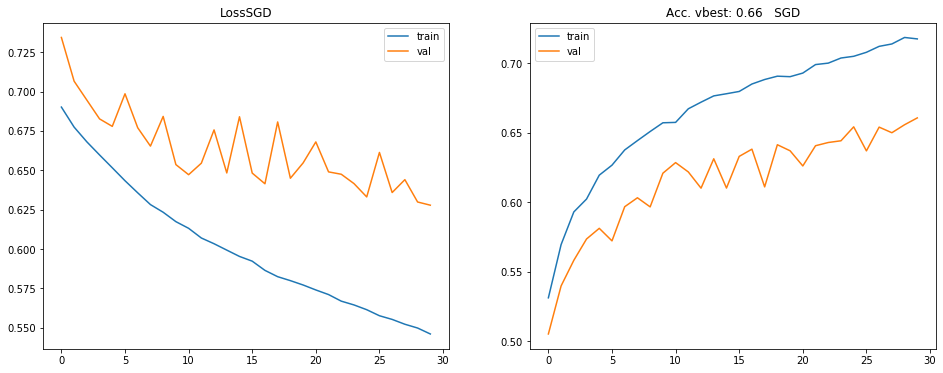

In [106]:
%%time

batch_size = 64                                                                                                    
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=len(vocab), kernel_size=5, embedding_dim=20).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, nesterov=True, momentum=0.01)     # <--- Adadelta()
lr_scheduler = None #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=learning_rate/100)   # <----- minimum learning rate setting.

history = tx.training_loop(30, 
                           optimizer, model, criterion,
                           data_loader['train'], data_loader['val'], 
                           hist=None, 
                           lr_scheduler=lr_scheduler,
                           device=device)
tx.plot_history(history, text=optimizer.__class__.__name__)